In [180]:
#wczytanie modelu
from tensorflow import keras
model = keras.models.load_model('siec.h5')

In [181]:
#zaimportowanie niezędnych bibliotek
import cv2
import numpy as np
import imutils
import os
from google.colab.patches import cv2_imshow

In [234]:
img  = cv2.imread('/content/80.jpg')  #wczytanie obrazu
#cv2_imshow(img) 
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #zamiana na przestrzeń hsv
#cv2_imshow(img_hsv) 

#wykrywanie czerwonych obszarów
lower_red = np.array([150,120,80])  #dolna granica czerwonego  
upper_red = np.array([180,255,255])  #górna granica czerwonego
mask = cv2.inRange(img_hsv, lower_red, upper_red)  #stworzenie maski
#cv2_imshow(mask) 
czerwony = cv2. bitwise_and(img, img, mask = mask)  #nałożenie maski na obraz - zostają czerwone obszary
#cv2_imshow(czerwony) 

img_gray = cv2.cvtColor(czerwony, cv2.COLOR_BGR2GRAY) #zamiana na skale szaarości
#cv2_imshow(img_gray) 

#drobna obróbka obrazu - filtracja, dylatacja i erozja
img_gray = cv2.GaussianBlur(img_gray, (5,5),0)
img_gray = cv2.dilate(img_gray, None, iterations=4)
img_gray = cv2.erode(img_gray, None, iterations=4)

#znalezienie konturów czerwonych obszarów
contours, _ = cv2.findContours(img_gray.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#wybranie największego czerwonego obszaru
c = max(contours, key=cv2.contourArea)

#znalezienie skrajnych punktów na wybranych konturze
lewy = tuple(c[c[:, :, 0].argmin()][0])
prawy = tuple(c[c[:, :, 0].argmax()][0])
gora = tuple(c[c[:, :, 1].argmin()][0])
dol = tuple(c[c[:, :, 1].argmax()][0])

#narysowanie konturów i punktów skrajnych na oryginalnym obrazie 
cv2.drawContours(img, [c], -1, (255, 0, 0), 1)
cv2.circle(img, lewy, 4, (0, 255, 255), -1)
cv2.circle(img, prawy, 4, (0, 255, 255), -1)
cv2.circle(img, gora, 4, (0, 255, 255), -1)
cv2.circle(img, dol, 4, (0, 255, 255), -1)
#cv2_imshow(img)

#przygotowanie współrzędnych do wycięcia pierwszej cyfry ze znaku
x1 = lewy[0]
x2 = int((gora[0]+dol[0])/2)
y1 = gora[1]
y2 = dol[1]

wys = y2-y1
szer = x2 - x1

a = y1 + int(wys/3.8)
b = y2 - int(wys/3.8)
c = x1 + int(szer/3.6)
d = x2 + int(szer/4)

#wycięcie pierwszej cyfry ze znaku
znak = img[a:b,c:d]
znak = cv2.cvtColor(znak, cv2.COLOR_BGR2GRAY) #zamana na skalę szarości

cv2_imshow(znak)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Prędkość: 80km/h
Prawdopodobieństwo: 0.99933285


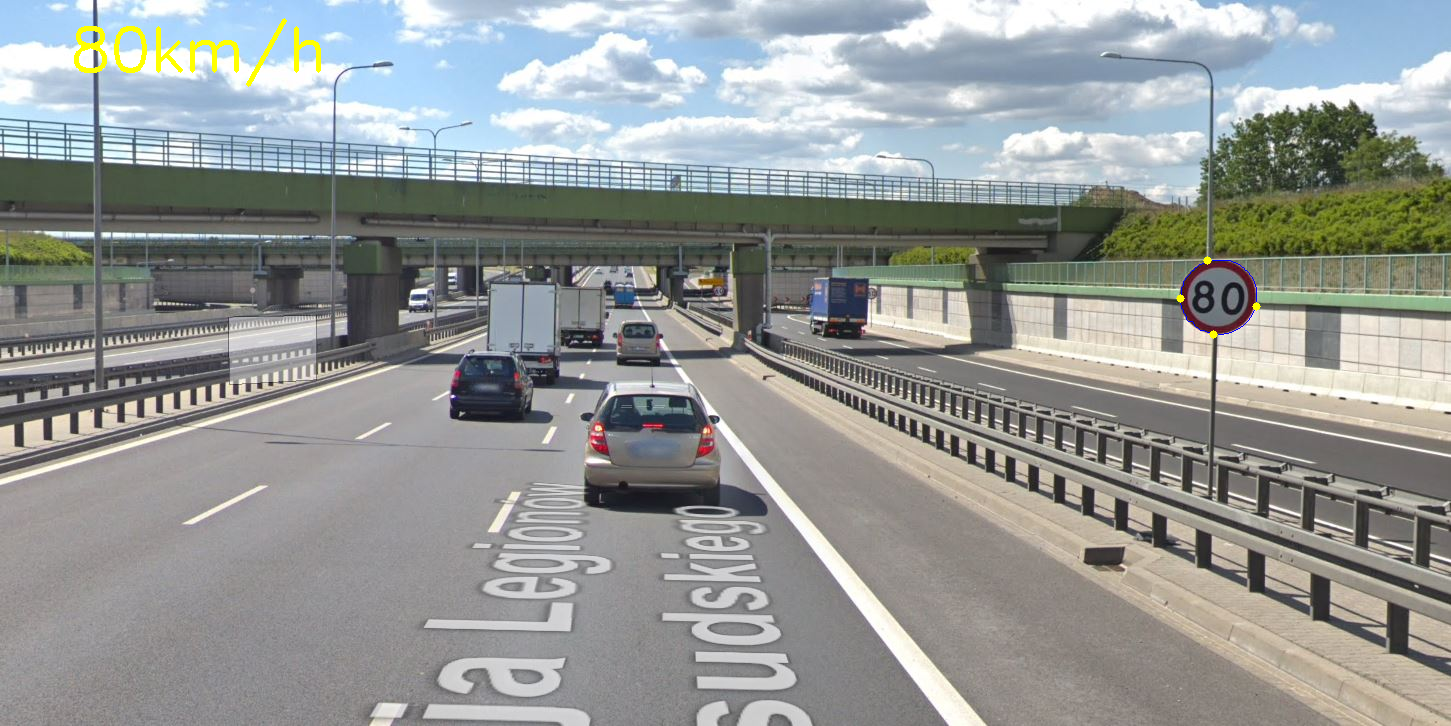

In [235]:
#przygotowanie wyciętego obrazu do rozpoznania przez model
znak = cv2.equalizeHist(znak) #wyrównanie histogramu
znak = znak/255 #normalizacja
znak = cv2.resize(znak,(32,32)) #stały rozmiar

znak = znak.reshape(1,32,32,1)  #odpowiednia zamiana kształtu, by umożliwić wysłanie obrazu do modelu

#rozpoznanie cyfry przez model
cyfra = model.predict_classes(znak)

#określenie maksymalnej predkosci na podstawie rozpoznanej pierwszej cyfry
predkosc = int(cyfra*10)
text =str(predkosc) +'km/h' #przygotowanie do wyświetlenia predkosci

print('Prędkość:',text)

#okreslenie prawdopodobieństwa poprawnego rozpoznania predkosci
predictions = model.predict(znak)
prawdop = np.amax(predictions) 
print('Prawdopodobieństwo:', prawdop)

#wyswietlenie obrazu wraz z predkoscią i zaznaczonm konturem znaku
cv2.putText(img, text, (70, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 3)
cv2_imshow(img)